# zinc_multi_task
- 3つの目的変数（logP, qed, sas）を同時に予測するGNNを構築する

### Results (Test, raw scale)

| Task | MAE | RMSE | R^2 |
|-----|------|-----|-----|
| logP | 0.059 | 0.077 | 0.989 |
| qed | 0.134 | 0.193 | 0.931 |
| SAS   | 0.098 | 0.134 | 0.967 |

## ライブラリ読み込み

In [6]:
import sys
import copy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from rdkit import Chem
from rdkit import __version__ as rdkit_version
from rdkit.Chem import Draw

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_add_pool
import torch_geometric

from tqdm import tqdm

import os
import json
from typing import List, Dict, Any, Tuple, Optional, Callable

# ------------------------------
# Reproducibility
# ------------------------------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------------------
# Device
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Environment info (for reproducibility)
# ------------------------------
print("===== Environment =====")
print(f"Python           : {sys.version.split()[0]}")
print(f"PyTorch          : {torch.__version__}")
print(f"PyTorch Geometric: {torch_geometric.__version__}")
print(f"RDKit            : {rdkit_version}")
if torch.cuda.is_available():
    print(f"CUDA version     : {torch.version.cuda}")
print("========================")
print("device:", device)

===== Environment =====
Python           : 3.9.23
PyTorch          : 2.2.1+cu121
PyTorch Geometric: 2.6.1
RDKit            : 2025.03.5
CUDA version     : 12.1
device: cuda


In [7]:
# ダウンロードしたデータセットを読み込む
dataset = pd.read_csv('data/zinc/zinc250k.csv')

print(dataset.shape)
display(dataset.head())

(249455, 7)


,smiles,logP,qed,SAS,mol,can_smiles,SELFIES
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095,<rdkit.Chem.rdchem.Mol object at 0x7f59da0ba660>,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,[C][C][Branch1][C][C][Branch1][C][C][C][=C][C]...
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004,<rdkit.Chem.rdchem.Mol object at 0x7f59da0ba5f0>,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,[C][C@@H1][C][C][Branch2][Ring1][Ring2][N][C][...
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633,<rdkit.Chem.rdchem.Mol object at 0x7f59da0ba890>,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,[N][#C][C][=C][C][=C][Branch2][Ring2][Ring2][C...
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753,<rdkit.Chem.rdchem.Mol object at 0x7f59da0ba740>,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,[C][C][O][C][=Branch1][C][=O][C@@H1][C][C][C][...
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182,<rdkit.Chem.rdchem.Mol object at 0x7f59da0ba970>,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,[N][#C][C][=C][Branch2][Ring1][Ring1][S][C][C]...


In [8]:
# smiles列
smiles_col = "smiles"

# 目的変数列
target_cols = ["logP", "qed", "SAS"]
required_cols = [smiles_col] + target_cols

# 必須列の欠損チェック
missing_cols = [c for c in required_cols if c not in dataset.columns]
if missing_cols:
    raise ValueError(f"dataset に必要列がありません: {missing_cols}. columns={list(dataset.columns)}")

# 目的変数列が欠損している行を除外
df = dataset[required_cols].dropna().reset_index(drop=True)

# 型の安全化（smilesはstr、ターゲットはnumeric）
df["smiles"] = df["smiles"].astype(str)
for col in target_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=target_cols).reset_index(drop=True)

print("Usable rows:", len(df))
display(df.head(3))

Usable rows: 249455


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633


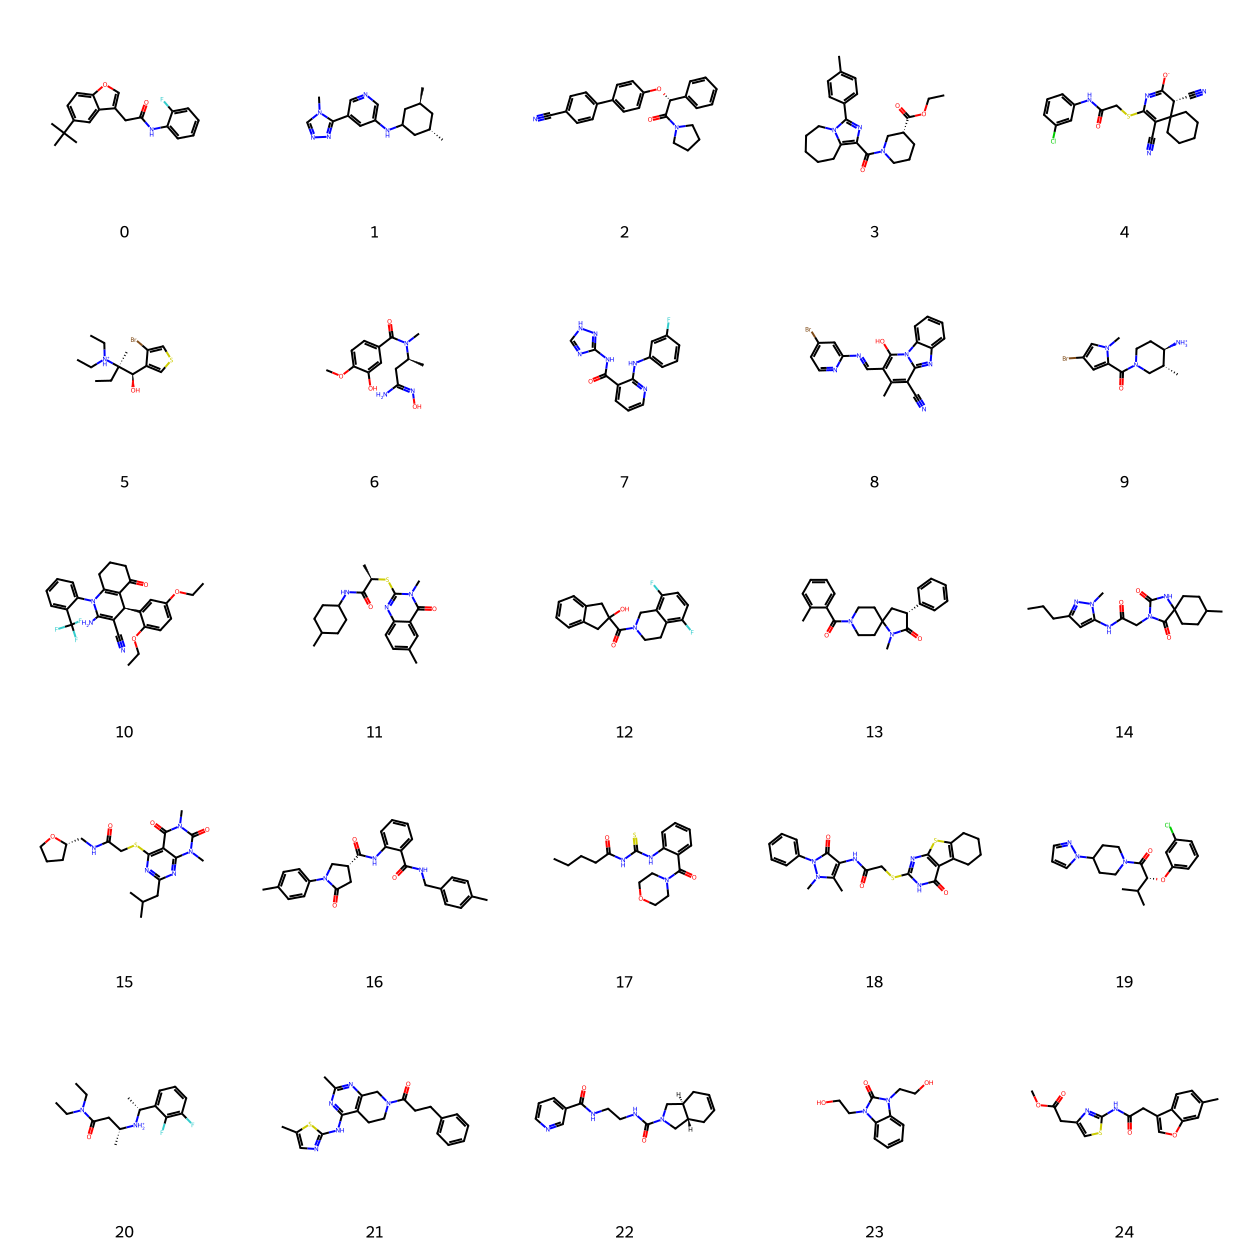

In [9]:
# 25分子を grid 形式で可視化（RDKit）

# Mol生成（失敗したSMILESはNoneになる）
mols = []
legends = []
for i, smi in enumerate(df[smiles_col].astype(str).head(25)):
    m = Chem.MolFromSmiles(smi)
    mols.append(m)
    legends.append(f"{i}")

# 表示
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=legends
)
display(img)

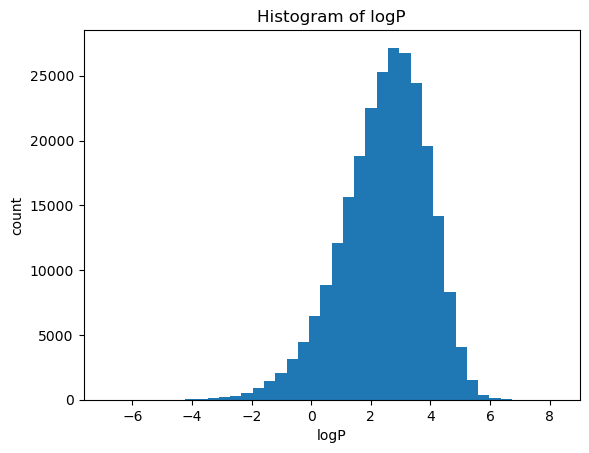

count: 249455
min / max: -6.8762 8.2521
mean / std: 2.457093002906336 1.4343296761376436
quantiles: {0.01: -1.48653, 0.05: -0.1262779999999998, 0.5: 2.6056, 0.95: 4.539229999999999, 0.99: 5.1581475999999995}


In [10]:
# 目的変数の可視化

# 目的変数のselect
target_col = "logP"
if target_col not in df.columns:
    raise ValueError(f"'{target_col}' 列がありません。利用可能列: {list(df.columns)}")

X = df[target_col].dropna()

plt.figure()
plt.hist(X, bins=40)
plt.title(f"Histogram of {target_col}")
plt.xlabel(f"{target_col}")
plt.ylabel("count")
plt.show()

print("count:", len(X))
print("min / max:", float(X.min()), float(X.max()))
print("mean / std:", float(X.mean()), float(X.std()))
print("quantiles:", X.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).to_dict())

In [ ]:
# ============================================================
# Hold-out split: train / val / test（ランダム分割）
# ============================================================

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,          # 全体の 20% を val + test に回す
    random_state=SEED,
    shuffle=True,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,          # temp の半分ずつ -> 各 10%
    random_state=SEED,
    shuffle=True,
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(
    "Hold-out split sizes ->",
    "train:", len(train_df),
    "val:", len(val_df),
    "test:", len(test_df),
)

# ============================================================
# Robust scaling: median = 0, IQR = 1（train のみで fit）
# ============================================================

def fit_robust_scaler(y: pd.Series):
    y = y.astype(float)
    med = float(y.median())
    q1 = float(y.quantile(0.25))
    q3 = float(y.quantile(0.75))
    iqr = q3 - q1
    if iqr == 0:
        iqr = 1.0
    return med, iqr

def transform_robust(y: pd.Series, med: float, iqr: float):
    return (y.astype(float) - med) / iqr

def inverse_robust(y_scaled, med: float, iqr: float):
    return y_scaled * iqr + med

# ---- train のみで fit ----
scalers = {col: fit_robust_scaler(train_df[col]) for col in target_cols}

# ---- 各 split に適用（コピーしてから列追加）----
train_df = train_df.copy()
val_df   = val_df.copy()
test_df  = test_df.copy()

for col in target_cols:
    med, iqr = scalers[col]
    train_df[f"{col}_scaled"] = transform_robust(train_df[col], med, iqr)
    val_df[f"{col}_scaled"]   = transform_robust(val_df[col],   med, iqr)
    test_df[f"{col}_scaled"]  = transform_robust(test_df[col],  med, iqr)

# ---- 確認ログ（ターゲット毎）----
for col in target_cols:
    med, iqr = scalers[col]
    q1 = float(train_df[f"{col}_scaled"].quantile(0.25))
    q3 = float(train_df[f"{col}_scaled"].quantile(0.75))
    print(
        f"[fit on train] {col}: median(raw)={med:.5g}, IQR(raw)={iqr:.5g} | "
        f"median(scaled)={float(train_df[f'{col}_scaled'].median()):.5g}, IQR(scaled)={(q3-q1):.5g}"
    )

Hold-out split sizes -> train: 199564 val: 24945 test: 24946
[fit on train] logP: median(raw)=2.6058, IQR(raw)=1.9118 | median(scaled)=0, IQR(scaled)=1
[fit on train] qed: median(raw)=0.75967, IQR(raw)=0.1898 | median(scaled)=0, IQR(scaled)=1
[fit on train] SAS: median(raw)=2.8928, IQR(raw)=1.129 | median(scaled)=0, IQR(scaled)=1


In [ ]:
# AD向けに保存しておく
train_df.to_csv('data/zinc/zinc250k_train_processed.csv', index=False)
val_df.to_csv('data/zinc/zinc250k_val_processed.csv', index=False)
test_df.to_csv('data/zinc/zinc250k_test_processed.csv', index=False)

## SMILES → PyTorch Geometric Data 変換（Dataset作成）

In [13]:
# ============================================================
# Features + SMILES -> PyG Data 変換
# （論文準拠の離散特徴量）
# ============================================================

# ----------------------------
# 原子・結合の離散特徴量設定
# ----------------------------

# 原子番号・次数の上限（クリップ用）
MAX_ATOMIC_NUM = 100
MAX_DEGREE = 5

# 結合タイプ（論文中の B 行列選択に対応）
BOND_TYPES = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
}
NUM_BOND_TYPES = 4

# ----------------------------
# 追加の原子特徴量
#  - 形式電荷
#  - 混成軌道
# ----------------------------

# 形式電荷（クリップして離散化）
MIN_FC, MAX_FC = -2, 2
FC_OFFSET = -MIN_FC               # -2..2 → 0..4
NUM_FC = (MAX_FC - MIN_FC + 1)

# 混成軌道タイプ
HYB_MAP = {
    Chem.rdchem.HybridizationType.SP: 0,
    Chem.rdchem.HybridizationType.SP2: 1,
    Chem.rdchem.HybridizationType.SP3: 2,
    Chem.rdchem.HybridizationType.SP3D: 3,
    Chem.rdchem.HybridizationType.SP3D2: 4,
}
HYB_UNKNOWN = 5
NUM_HYB = 6

def atom_features(atom: Chem.rdchem.Atom) -> torch.Tensor:
    """
    原子特徴量（すべて離散値）
    x[:, :] の各列の意味：
      x[:,0]: 原子番号（クリップあり）
      x[:,1]: 原子次数（クリップあり）
      x[:,2]: 芳香族フラグ（0/1）
      x[:,3]: 形式電荷（-2..2 を 0..4 に変換）
      x[:,4]: 混成軌道タイプ
    """
    atomic_num = min(atom.GetAtomicNum(), MAX_ATOMIC_NUM)
    degree = min(atom.GetDegree(), MAX_DEGREE)
    aromatic = int(atom.GetIsAromatic())

    # 形式電荷をクリップしてオフセット
    formal_charge = atom.GetFormalCharge()
    formal_charge = max(MIN_FC, min(formal_charge, MAX_FC)) + FC_OFFSET  # 0..NUM_FC-1

    # 混成軌道（未知は HYB_UNKNOWN）
    hyb_idx = HYB_MAP.get(atom.GetHybridization(), HYB_UNKNOWN)

    return torch.tensor([atomic_num, degree, aromatic, formal_charge, hyb_idx], dtype=torch.long)

def bond_features(bond: Chem.rdchem.Bond) -> torch.Tensor:
    """
    結合特徴量（離散）
    edge_attr[:, :] の各列の意味：
      edge_attr[:,0]: 結合タイプ（SINGLE/DOUBLE/TRIPLE/AROMATIC）
      edge_attr[:,1]: 共役フラグ（0/1）
      edge_attr[:,2]: 環内結合フラグ（0/1）
    """
    bond_type = BOND_TYPES.get(bond.GetBondType(), 0)
    conjugated = int(bond.GetIsConjugated())
    in_ring = int(bond.IsInRing())
    return torch.tensor([bond_type, conjugated, in_ring], dtype=torch.long)


def smiles_to_pyg(smiles: str, y_values: list):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # ノード特徴
    x = torch.stack([atom_features(a) for a in mol.GetAtoms()], dim=0)  # [N, 5]

    # エッジ（無向→両方向）
    edge_index_list, edge_attr_list = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bf = bond_features(bond)
        edge_index_list += [[i, j], [j, i]]
        edge_attr_list  += [bf, bf]

    if len(edge_index_list) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr  = torch.empty((0, 3), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr  = torch.stack(edge_attr_list, dim=0)

    # 目的変数（num_tasks 可変）
    y = torch.tensor(y_values, dtype=torch.float).view(1, -1)  # [1, T]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.smiles = smiles
    return data


class SmilesGraphDataset(Dataset):
    """
    DataFrame（SMILES + 目的変数）から PyG Data のリストを作る Dataset
    """
    def __init__(
        self,
        df: pd.DataFrame,
        smiles_col: str,
        target_cols: list,
        use_scaled: bool = True,
    ):
        self.data_list = []
        bad = 0

        y_cols = [f"{c}_scaled" for c in target_cols] if use_scaled else target_cols

        # 必須列チェック（ここで落とす）
        needed = [smiles_col] + y_cols
        missing = [c for c in needed if c not in df.columns]
        if missing:
            raise ValueError(f"df に必要列がありません: {missing}. columns={list(df.columns)}")

        for _, row in df.iterrows():
            smi = row[smiles_col]
            y_vals = [row[c] for c in y_cols]
            d = smiles_to_pyg(smi, y_vals)
            if d is None:
                bad += 1
            else:
                self.data_list.append(d)

        print(f"Converted graphs: {len(self.data_list)} / {len(df)} (invalid smiles removed: {bad})")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

# --- Build datasets from scaffold split ---
train_dataset = SmilesGraphDataset(train_df, smiles_col=smiles_col, target_cols=target_cols, use_scaled=True)
val_dataset   = SmilesGraphDataset(val_df,   smiles_col=smiles_col, target_cols=target_cols, use_scaled=True)
test_dataset  = SmilesGraphDataset(test_df,  smiles_col=smiles_col, target_cols=target_cols, use_scaled=True)

# quick check
d0 = train_dataset[0]
print(d0)
print("y:", d0.y)

Converted graphs: 199564 / 199564 (invalid smiles removed: 0)
Converted graphs: 24945 / 24945 (invalid smiles removed: 0)
Converted graphs: 24946 / 24946 (invalid smiles removed: 0)
Data(x=[20, 5], edge_index=[2, 44], edge_attr=[44, 3], y=[1, 3], smiles='COc1nc(Oc2ccc3ccccc3c2)ccc1N
')
y: tensor([[ 0.5294,  0.0341, -0.7915]])


## PyG DataLoader（ミニバッチ化）＋バッチの形確認

In [14]:
# DataLoader + sanity check

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# 1バッチ取り出して形確認
batch = next(iter(train_loader))
print(batch)

print("batch.x:", batch.x.shape)               # [total_nodes_in_batch, 5]
print("batch.edge_index:", batch.edge_index.shape)
print("batch.edge_attr:", batch.edge_attr.shape)
print("batch.y:", batch.y.shape)               # [num_graphs_in_batch, num_tasks]
print("batch.batch:", batch.batch.shape)       # [total_nodes_in_batch]
print("num_graphs:", batch.num_graphs)

# 明示的に期待shapeを出す（混乱防止）
num_tasks = batch.y.size(-1) if batch.y.ndim == 2 else 1
print("inferred num_tasks:", num_tasks)

# GPUに乗せてみる（エラー出ないか確認）
batch = batch.to(device)
print("moved to device OK")

DataBatch(x=[756, 5], edge_index=[2, 1630], edge_attr=[1630, 3], y=[32, 3], smiles=[32], batch=[756], ptr=[33])
batch.x: torch.Size([756, 5])
batch.edge_index: torch.Size([2, 1630])
batch.edge_attr: torch.Size([1630, 3])
batch.y: torch.Size([32, 3])
batch.batch: torch.Size([756])
num_graphs: 32
inferred num_tasks: 3
moved to device OK


## 2D-only MPNN（PyG）モデル定義（Embedding → MessagePassing → Pooling → 回帰）

In [15]:
# ============================================================
#   Model  : bond-type-specific matrices + GRU update
#   message: m_ij = W_{bond_type} h_j
#   update : h_i <- GRU(m_i, h_i)
#   readout: 1024-d fingerprint (sum over nodes)
#   head   : 1024 -> 512 -> 256 -> out (BN + ReLU)
# ============================================================

class EdgeCondLinearLayer(MessagePassing):
    """
    論文の (B) に対応：
      m_{ij} = W_{bond_type} h_j
    を作ってから、GRUでノード状態を更新する層。
    """
    def __init__(self, hidden_dim: int, num_bond_types: int):
        super().__init__(aggr="add")  # 近傍メッセージを加算で集約
        self.hidden_dim = hidden_dim
        self.num_bond_types = num_bond_types

        # 結合タイプごとの重み行列 W_e: [T, H, H]
        self.W = nn.Parameter(torch.empty(num_bond_types, hidden_dim, hidden_dim))
        nn.init.xavier_uniform_(self.W)

        # GRU: input=message, hidden=old_state
        self.gru = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, x, edge_index, bond_type):
        """
        x        : [N, H]  ノード表現
        edge_index: [2, E] 有向エッジ
        bond_type : [E]    エッジごとの結合タイプ（0..T-1）
        """
        # propagate() は message() を呼び、aggr="add" でノードごとに集約する
        m = self.propagate(edge_index, x=x, bond_type=bond_type)  # [N, H]

        # GRUで更新（input=m, hx=x）
        x_out = self.gru(m, x)  # [N, H]
        return x_out

    def message(self, x_j, bond_type):
        """
        x_j      : [E, H]  エッジの送信元ノード表現（j側）
        bond_type: [E]     結合タイプ
        """
        bt = bond_type.clamp(0, self.num_bond_types - 1)  # 安全のため範囲に収める

        # エッジごとに W_{bt} を選ぶ → [E, H, H]
        W_bt = self.W[bt]

        # m_ij = W_{bt} @ h_j
        m = torch.bmm(W_bt, x_j.unsqueeze(-1)).squeeze(-1)  # [E, H]
        return m


class MPNNRegressor(nn.Module):
    """
    論文準拠の構成（要点）：
      - ノード隠れ次元: 128
      - Message Passing 回数: M=3（num_layers）
      - 分子fingerprint: 1024次元（和集合=ノード和）
      - Head: (BN+ReLU付き) 1024 -> 512 -> 256 -> out
    """
    def __init__(
        self,
        hidden_dim: int = 128,
        num_layers: int = 3,
        num_targets: int = 3,
        dropout: float = 0.0,
    ):
        super().__init__()

        # ----------------------------
        # (1) ノード特徴の埋め込み（離散特徴 → embedding → concat）
        # ----------------------------
        self.emb_atomic = nn.Embedding(MAX_ATOMIC_NUM + 1, 64)
        self.emb_degree = nn.Embedding(MAX_DEGREE + 1, 16)
        self.emb_aroma  = nn.Embedding(2, 8)
        self.emb_fc     = nn.Embedding(NUM_FC, 8)
        self.emb_hyb    = nn.Embedding(NUM_HYB, 8)

        node_in_dim = 64 + 16 + 8 + 8 + 8  # = 104
        self.node_proj = nn.Linear(node_in_dim, hidden_dim)  # 104 -> 128

        # ----------------------------
        # (2) Message Passing 層（B: bond-type別行列 + GRU更新）
        # ----------------------------
        self.layers = nn.ModuleList([
            EdgeCondLinearLayer(hidden_dim=hidden_dim, num_bond_types=NUM_BOND_TYPES)
            for _ in range(num_layers)  # M = num_layers
        ])

        # ----------------------------
        # (3) Readout: ノード -> 1024 次元に写像してから sum pool
        #     fingerprint g ∈ R^{1024}
        # ----------------------------
        self.fp_dim = 1024
        self.node_to_fp = nn.Linear(hidden_dim, self.fp_dim)

        # ----------------------------
        # (4) Head: 1024 -> 512 -> 256 -> out（BN + ReLU）
        # ----------------------------
        self.fc1 = nn.Linear(self.fp_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.out = nn.Linear(256, num_targets)

        self.dropout = dropout

    def forward(self, data):
        """
        data.x        : [N, 5]  (long) 原子の離散特徴
        data.edge_index: [2, E]
        data.edge_attr : [E, 3] (long) 結合特徴（0列目が bond_type）
        data.batch     : [N]    各ノードが属するグラフID
        """
        x = data.x
        edge_index = data.edge_index
        edge_attr  = data.edge_attr
        batch      = data.batch

        # ----------------------------
        # ノード埋め込み（v2: 5特徴）
        # ----------------------------
        atomic_num      = x[:, 0].clamp(0, MAX_ATOMIC_NUM)
        degree          = x[:, 1].clamp(0, MAX_DEGREE)
        aromatic        = x[:, 2].clamp(0, 1)
        formal_charge   = x[:, 3].clamp(0, NUM_FC - 1)
        hybridization   = x[:, 4].clamp(0, NUM_HYB - 1)

        h = torch.cat([
            self.emb_atomic(atomic_num),
            self.emb_degree(degree),
            self.emb_aroma(aromatic),
            self.emb_fc(formal_charge),
            self.emb_hyb(hybridization),
        ], dim=-1)                       # [N, 104]

        h = self.node_proj(h)            # [N, 128]

        # ----------------------------
        # bond_type（行列選択に使う）
        # ----------------------------
        bond_type = edge_attr[:, 0].clamp(0, NUM_BOND_TYPES - 1)  # [E]

        # ----------------------------
        # Message Passing（M回）
        # ----------------------------
        for layer in self.layers:
            h = layer(h, edge_index, bond_type)  # [N, 128]

        # ----------------------------
        # Readout: 1024-d fingerprint
        # 1) ノード表現を 1024次元に写像
        # 2) 分子ごとに sum pool（global_add_pool）
        # ----------------------------
        h_fp = self.node_to_fp(h)                 # [N, 1024]
        g    = global_add_pool(h_fp, batch)       # [B, 1024]  (B = num_graphs)

        # ----------------------------
        # Head: 1024 -> 512 -> 256 -> out
        # （各層 BatchNorm + ReLU）
        # ----------------------------
        z = self.bn1(self.fc1(g))
        z = F.relu(z)
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        z = self.bn2(self.fc2(z))
        z = F.relu(z)
        if self.dropout > 0:
            z = F.dropout(z, p=self.dropout, training=self.training)

        out = self.out(z)                         # [B, num_targets]
        return out

In [16]:
# 動作確認
num_targets = len(target_cols)
model = MPNNRegressor(hidden_dim=128, num_layers=3, num_targets=num_targets, dropout=0).to(device)
batch = next(iter(train_loader)).to(device)
pred = model(batch)

print("pred shape:", pred.shape)  # [batch_size]
print("y shape:", batch.y.shape)
print("pred sample:", pred[:5].detach().cpu())
print("y sample:", batch.y[:5].detach().cpu())

pred shape: torch.Size([32, 3])
y shape: torch.Size([32, 3])
pred sample: tensor([[-0.0337,  0.0793, -0.1301],
        [ 0.0698,  0.0849,  0.1345],
        [ 0.6959,  0.5640,  0.1588],
        [-0.0298,  0.0959, -0.0161],
        [ 0.1715, -0.5156,  0.1767]])
y sample: tensor([[-0.2326, -0.2232, -0.8393],
        [-0.2005,  0.1216, -0.0313],
        [-1.4543, -1.9053,  0.8875],
        [ 0.6907, -0.5977, -0.5037],
        [-0.4011, -0.2827, -0.7896]])


## 学習・評価

In [17]:
# --- 損失関数 ---
# マルチタスク回帰（Tタスク）なので、各要素の MSE の平均をとる
criterion = nn.MSELoss()

# --- 最適化手法 ---
# 論文で最良とされている学習率 1e-3 の Adam
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.0
)

# --- 学習率スケジューラ ---
# 論文の「エポックごとに 2×10^-6 の減衰」を
# 指数減衰として解釈し、epoch ごとに lr を少しずつ下げる
#   lr_{t+1} = lr_t * (1 - 2e-6)
decay = 2e-6
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: (1.0 - decay) ** epoch
)


def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    1エポック分の学習を行う関数

    Returns
    -------
    train_mse : float
        分子あたり平均 MSE（scaled 空間）
    train_mae : float
        分子あたり平均 MAE（scaled 空間、8物性平均）
    """
    model.train()
    total_loss = 0.0
    total_mae = 0.0
    n = 0  # 分子数カウント

    for batch in tqdm(loader, desc="train", leave=False):
        batch = batch.to(device)

        # 勾配の初期化
        optimizer.zero_grad()

        # --- 順伝播 ---
        pred = model(batch)        # [B, T]（scaled）
        y = batch.y.float()        # [B, T]（scaled）

        # --- 損失計算 ---
        loss = criterion(pred, y)

        # --- 逆伝播 & 更新 ---
        loss.backward()
        optimizer.step()

        # --- MAE を参考指標として計算 ---
        with torch.no_grad():
            mae = torch.mean(torch.abs(pred - y))

        bsz = batch.num_graphs
        total_loss += loss.item() * bsz
        total_mae  += mae.item()  * bsz
        n += bsz

    return total_loss / n, total_mae / n


@torch.no_grad()
def evaluate_scaled(model, loader, device, target_cols):
    """
    scaled 空間での評価

    Returns
    -------
    results : dict
        {target: {mae, rmse, r2}}
    """
    model.eval()
    preds, ys = [], []

    for batch in tqdm(loader, desc="eval_scaled", leave=False):
        batch = batch.to(device)
        pred = model(batch).cpu()   # [B, T]
        y = batch.y.cpu()           # [B, T]
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0)  # [N, T]
    ys    = torch.cat(ys, dim=0)     # [N, T]

    results = {}
    for i, col in enumerate(target_cols):
        resid = preds[:, i] - ys[:, i]

        mae = resid.abs().mean().item()
        rmse = torch.sqrt((resid ** 2).mean()).item()

        # 決定係数 R^2
        y_mean = ys[:, i].mean()
        ss_tot = torch.sum((ys[:, i] - y_mean) ** 2)
        ss_res = torch.sum(resid ** 2)
        r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

        results[col] = {"mae": mae, "rmse": rmse, "r2": r2}

    # ===== ここに追加 =====
    results["_macro"] = {
        "mae": float(np.mean([results[c]["mae"] for c in target_cols])),
        "rmse": float(np.mean([results[c]["rmse"] for c in target_cols])),
        "r2": float(np.mean([results[c]["r2"] for c in target_cols])),
    }

    return results


@torch.no_grad()
def evaluate_raw(model, loader, device, target_cols, scalers):
    """
    元のスケール（robust scaling を逆変換）での評価

    Returns
    -------
    results : dict
        {target: {mae, rmse, r2}}
    """
    model.eval()
    preds, ys = [], []

    for batch in tqdm(loader, desc="eval_raw", leave=False):
        batch = batch.to(device)
        pred = model(batch).cpu()   # scaled
        y = batch.y.cpu()           # scaled
        preds.append(pred)
        ys.append(y)

    preds = torch.cat(preds, dim=0)
    ys    = torch.cat(ys, dim=0)

    results = {}
    for i, col in enumerate(target_cols):
        med, iqr = scalers[col]

        # robust scaling の逆変換
        pred_raw = preds[:, i] * iqr + med
        y_raw    = ys[:, i] * iqr + med

        resid = pred_raw - y_raw
        mae = resid.abs().mean().item()
        rmse = torch.sqrt((resid ** 2).mean()).item()

        y_mean = y_raw.mean()
        ss_tot = torch.sum((y_raw - y_mean) ** 2)
        ss_res = torch.sum(resid ** 2)
        r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

        results[col] = {"mae": mae, "rmse": rmse, "r2": r2}

    # ===== ここに追加 =====
    results["_macro"] = {
        "mae": float(np.mean([results[c]["mae"] for c in target_cols])),
        "rmse": float(np.mean([results[c]["rmse"] for c in target_cols])),
        "r2": float(np.mean([results[c]["r2"] for c in target_cols])),
    }

    return results


def results_to_df(results: dict, title: str):
    """
    評価結果を DataFrame にまとめて表示
    """
    dfm = pd.DataFrame(results).T
    dfm.index.name = "target"
    dfm = dfm[["mae", "rmse", "r2"]]
    print(f"\n[{title}]")
    print(dfm)
    return dfm

In [18]:
# 最大エポック数
max_epochs = 500

# early stopping の patience
patience = 20

# early stopping / モニタリング対象
# 例1) タスク単体で監視: monitor_col = target_cols[0]
# 例2) 全体平均で監視（推奨）: monitor_col = "_macro"
monitor_col = "_macro"
monitor_key = "rmse"   # "rmse" or "mae"

best_metric = float("inf")
best_state = None
bad_epochs = 0

history = []

# ログに表示するターゲット（最大3つ程度）
# ZINCなら ["logP","qed","SAS"]、OPV単タスクなら ["gap"] みたいになる
show_cols = target_cols[:3] if len(target_cols) >= 3 else target_cols

for epoch in range(1, max_epochs + 1):

    # 1) Train
    train_mse, train_mae = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # 2) Validation（scaled）
    val_scaled = evaluate_scaled(
        model, val_loader, device, target_cols
    )

    # early stopping 判定に使う指標
    if monitor_col not in val_scaled:
        raise KeyError(f"monitor_col='{monitor_col}' が val_scaled にありません: keys={list(val_scaled.keys())}")
    current = val_scaled[monitor_col][monitor_key]

    # 3) LR step
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]

    # 4) ログ出力（macro + 代表タスク）
    macro = val_scaled["_macro"]
    parts = [
        f"[Epoch {epoch:03d}] lr={lr:.2e}",
        f"train_MSE={train_mse:.4f} train_MAE={train_mae:.4f}",
        f"VAL_macro_RMSE={macro['rmse']:.4f} macro_MAE={macro['mae']:.4f} macro_R2={macro['r2']:.4f}",
    ]
    for c in show_cols:
        r = val_scaled[c]
        parts.append(f"VAL {c}_RMSE={r['rmse']:.4f} {c}_MAE={r['mae']:.4f} {c}_R2={r['r2']:.4f}")
    print(" | ".join(parts))

    # ログ保存（macro + 各タスクRMSE）
    row = {
        "epoch": epoch,
        "lr": lr,
        "train_mse": train_mse,
        "train_mae": train_mae,
        f"val_{monitor_col}_{monitor_key}": current,
        "val_macro_rmse": macro["rmse"],
        "val_macro_mae": macro["mae"],
        "val_macro_r2": macro["r2"],
    }
    for c in target_cols:
        row[f"val_{c}_rmse"] = val_scaled[c]["rmse"]
        row[f"val_{c}_mae"] = val_scaled[c]["mae"]
        row[f"val_{c}_r2"] = val_scaled[c]["r2"]
    history.append(row)

    # 5) Early stopping
    if current < best_metric - 1e-6:
        best_metric = current
        best_state = copy.deepcopy(model.state_dict())
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(
                f"Early stopping triggered (patience={patience}). "
                f"Best VAL {monitor_col}_{monitor_key}={best_metric:.4f}"
            )
            break

# 6) 最良モデルを復元
if best_state is not None:
    model.load_state_dict(best_state)

model.to(device).eval()

# 復元後に Validation を再評価
val_scaled_best = evaluate_scaled(model, val_loader, device, target_cols)

print("\n===== BEST MODEL: VAL (scaled) =====")
print(
    f"monitor: {monitor_col}_{monitor_key} = "
    f"{val_scaled_best[monitor_col][monitor_key]:.4f}"
)

# 7) Final evaluation on TEST（scaled + raw）
test_scaled = evaluate_scaled(model, test_loader, device, target_cols)
test_raw    = evaluate_raw(model, test_loader, device, target_cols, scalers)

print("\n===== FINAL TEST (scaled space) =====")
for k in (["_macro"] + show_cols):
    print(k, test_scaled[k])

print("\n===== FINAL TEST (raw space) =====")
for k in (["_macro"] + show_cols):
    print(k, test_raw[k])

test_scaled_df = results_to_df(test_scaled, "TEST scaled metrics")
test_raw_df    = results_to_df(test_raw,    "TEST raw metrics")

train:   0%|          | 0/6237 [00:00<?, ?it/s]

[Epoch 001] lr=1.00e-03 | train_MSE=0.0682 train_MAE=0.1903 | VAL_macro_RMSE=0.1716 macro_MAE=0.1299 macro_R2=0.9386 | VAL logP_RMSE=0.1009 logP_MAE=0.0793 logP_R2=0.9817 | VAL qed_RMSE=0.2499 qed_MAE=0.1821 qed_R2=0.8837 | VAL SAS_RMSE=0.1641 SAS_MAE=0.1284 SAS_R2=0.9505


[Epoch 002] lr=1.00e-03 | train_MSE=0.0427 train_MAE=0.1526 | VAL_macro_RMSE=0.1577 macro_MAE=0.1182 macro_R2=0.9520 | VAL logP_RMSE=0.1270 logP_MAE=0.1061 logP_R2=0.9710 | VAL qed_RMSE=0.2058 qed_MAE=0.1459 qed_R2=0.9211 | VAL SAS_RMSE=0.1403 SAS_MAE=0.1027 SAS_R2=0.9638


[Epoch 003] lr=1.00e-03 | train_MSE=0.0372 train_MAE=0.1419 | VAL_macro_RMSE=0.1373 macro_MAE=0.1003 macro_R2=0.9622 | VAL logP_RMSE=0.0869 logP_MAE=0.0687 logP_R2=0.9864 | VAL qed_RMSE=0.1846 qed_MAE=0.1272 qed_R2=0.9365 | VAL SAS_RMSE=0.1403 SAS_MAE=0.1050 SAS_R2=0.9638


[Epoch 004] lr=1.00e-03 | train_MSE=0.0353 train_MAE=0.1373 | VAL_macro_RMSE=0.1492 macro_MAE=0.1111 macro_R2=0.9553 | VAL logP_RMSE=0.1056 logP_MAE=0.0843 logP_R2=0.9800 | VAL qed_RMSE=0.2094 qed_MAE=0.1516 qed_R2=0.9183 | VAL SAS_RMSE=0.1326 SAS_MAE=0.0973 SAS_R2=0.9677


[Epoch 005] lr=1.00e-03 | train_MSE=0.0354 train_MAE=0.1372 | VAL_macro_RMSE=0.1444 macro_MAE=0.1046 macro_R2=0.9577 | VAL logP_RMSE=0.0954 logP_MAE=0.0734 logP_R2=0.9837 | VAL qed_RMSE=0.2040 qed_MAE=0.1442 qed_R2=0.9225 | VAL SAS_RMSE=0.1340 SAS_MAE=0.0961 SAS_R2=0.9670


[Epoch 006] lr=1.00e-03 | train_MSE=0.0357 train_MAE=0.1375 | VAL_macro_RMSE=0.1371 macro_MAE=0.0977 macro_R2=0.9602 | VAL logP_RMSE=0.0727 logP_MAE=0.0549 logP_R2=0.9905 | VAL qed_RMSE=0.2005 qed_MAE=0.1373 qed_R2=0.9251 | VAL SAS_RMSE=0.1382 SAS_MAE=0.1009 SAS_R2=0.9649


[Epoch 007] lr=1.00e-03 | train_MSE=0.0359 train_MAE=0.1372 | VAL_macro_RMSE=0.1460 macro_MAE=0.1072 macro_R2=0.9559 | VAL logP_RMSE=0.0844 logP_MAE=0.0663 logP_R2=0.9872 | VAL qed_RMSE=0.2075 qed_MAE=0.1469 qed_R2=0.9198 | VAL SAS_RMSE=0.1462 SAS_MAE=0.1083 SAS_R2=0.9607


[Epoch 008] lr=1.00e-03 | train_MSE=0.0363 train_MAE=0.1378 | VAL_macro_RMSE=0.1503 macro_MAE=0.1068 macro_R2=0.9525 | VAL logP_RMSE=0.0817 logP_MAE=0.0598 logP_R2=0.9880 | VAL qed_RMSE=0.2175 qed_MAE=0.1516 qed_R2=0.9119 | VAL SAS_RMSE=0.1517 SAS_MAE=0.1090 SAS_R2=0.9577


[Epoch 009] lr=1.00e-03 | train_MSE=0.0377 train_MAE=0.1401 | VAL_macro_RMSE=0.1630 macro_MAE=0.1192 macro_R2=0.9448 | VAL logP_RMSE=0.0856 logP_MAE=0.0644 logP_R2=0.9868 | VAL qed_RMSE=0.2215 qed_MAE=0.1526 qed_R2=0.9086 | VAL SAS_RMSE=0.1819 SAS_MAE=0.1407 SAS_R2=0.9391


[Epoch 010] lr=1.00e-03 | train_MSE=0.0389 train_MAE=0.1419 | VAL_macro_RMSE=0.1577 macro_MAE=0.1133 macro_R2=0.9484 | VAL logP_RMSE=0.0918 logP_MAE=0.0692 logP_R2=0.9849 | VAL qed_RMSE=0.2266 qed_MAE=0.1598 qed_R2=0.9043 | VAL SAS_RMSE=0.1548 SAS_MAE=0.1108 SAS_R2=0.9559


[Epoch 011] lr=1.00e-03 | train_MSE=0.0411 train_MAE=0.1462 | VAL_macro_RMSE=0.1695 macro_MAE=0.1206 macro_R2=0.9399 | VAL logP_RMSE=0.0966 logP_MAE=0.0721 logP_R2=0.9832 | VAL qed_RMSE=0.2470 qed_MAE=0.1705 qed_R2=0.8864 | VAL SAS_RMSE=0.1648 SAS_MAE=0.1193 SAS_R2=0.9501


[Epoch 012] lr=1.00e-03 | train_MSE=0.0423 train_MAE=0.1490 | VAL_macro_RMSE=0.1676 macro_MAE=0.1205 macro_R2=0.9439 | VAL logP_RMSE=0.1096 logP_MAE=0.0839 logP_R2=0.9784 | VAL qed_RMSE=0.2270 qed_MAE=0.1568 qed_R2=0.9040 | VAL SAS_RMSE=0.1663 SAS_MAE=0.1207 SAS_R2=0.9492


[Epoch 013] lr=1.00e-03 | train_MSE=0.0434 train_MAE=0.1500 | VAL_macro_RMSE=0.1681 macro_MAE=0.1218 macro_R2=0.9411 | VAL logP_RMSE=0.0943 logP_MAE=0.0706 logP_R2=0.9840 | VAL qed_RMSE=0.2408 qed_MAE=0.1714 qed_R2=0.8920 | VAL SAS_RMSE=0.1692 SAS_MAE=0.1233 SAS_R2=0.9474


[Epoch 014] lr=1.00e-03 | train_MSE=0.0430 train_MAE=0.1495 | VAL_macro_RMSE=0.1733 macro_MAE=0.1258 macro_R2=0.9386 | VAL logP_RMSE=0.1011 logP_MAE=0.0754 logP_R2=0.9816 | VAL qed_RMSE=0.2393 qed_MAE=0.1669 qed_R2=0.8933 | VAL SAS_RMSE=0.1794 SAS_MAE=0.1351 SAS_R2=0.9408


[Epoch 015] lr=1.00e-03 | train_MSE=0.0416 train_MAE=0.1464 | VAL_macro_RMSE=0.1643 macro_MAE=0.1192 macro_R2=0.9435 | VAL logP_RMSE=0.0926 logP_MAE=0.0691 logP_R2=0.9846 | VAL qed_RMSE=0.2383 qed_MAE=0.1699 qed_R2=0.8942 | VAL SAS_RMSE=0.1620 SAS_MAE=0.1185 SAS_R2=0.9518


[Epoch 016] lr=1.00e-03 | train_MSE=0.0419 train_MAE=0.1467 | VAL_macro_RMSE=0.1691 macro_MAE=0.1206 macro_R2=0.9409 | VAL logP_RMSE=0.0989 logP_MAE=0.0740 logP_R2=0.9824 | VAL qed_RMSE=0.2404 qed_MAE=0.1658 qed_R2=0.8923 | VAL SAS_RMSE=0.1681 SAS_MAE=0.1220 SAS_R2=0.9481


[Epoch 017] lr=1.00e-03 | train_MSE=0.0415 train_MAE=0.1460 | VAL_macro_RMSE=0.1758 macro_MAE=0.1259 macro_R2=0.9363 | VAL logP_RMSE=0.0997 logP_MAE=0.0725 logP_R2=0.9821 | VAL qed_RMSE=0.2455 qed_MAE=0.1714 qed_R2=0.8877 | VAL SAS_RMSE=0.1822 SAS_MAE=0.1338 SAS_R2=0.9390


[Epoch 018] lr=1.00e-03 | train_MSE=0.0425 train_MAE=0.1483 | VAL_macro_RMSE=0.1740 macro_MAE=0.1267 macro_R2=0.9375 | VAL logP_RMSE=0.0975 logP_MAE=0.0709 logP_R2=0.9829 | VAL qed_RMSE=0.2429 qed_MAE=0.1750 qed_R2=0.8901 | VAL SAS_RMSE=0.1817 SAS_MAE=0.1342 SAS_R2=0.9393


[Epoch 019] lr=1.00e-03 | train_MSE=0.0427 train_MAE=0.1487 | VAL_macro_RMSE=0.1709 macro_MAE=0.1200 macro_R2=0.9401 | VAL logP_RMSE=0.1015 logP_MAE=0.0737 logP_R2=0.9815 | VAL qed_RMSE=0.2401 qed_MAE=0.1654 qed_R2=0.8926 | VAL SAS_RMSE=0.1713 SAS_MAE=0.1209 SAS_R2=0.9461


[Epoch 020] lr=1.00e-03 | train_MSE=0.0415 train_MAE=0.1460 | VAL_macro_RMSE=0.1689 macro_MAE=0.1196 macro_R2=0.9406 | VAL logP_RMSE=0.0930 logP_MAE=0.0661 logP_R2=0.9844 | VAL qed_RMSE=0.2400 qed_MAE=0.1648 qed_R2=0.8927 | VAL SAS_RMSE=0.1737 SAS_MAE=0.1278 SAS_R2=0.9445


[Epoch 021] lr=1.00e-03 | train_MSE=0.0414 train_MAE=0.1460 | VAL_macro_RMSE=0.1731 macro_MAE=0.1273 macro_R2=0.9377 | VAL logP_RMSE=0.0942 logP_MAE=0.0681 logP_R2=0.9840 | VAL qed_RMSE=0.2430 qed_MAE=0.1768 qed_R2=0.8900 | VAL SAS_RMSE=0.1820 SAS_MAE=0.1371 SAS_R2=0.9391


[Epoch 022] lr=1.00e-03 | train_MSE=0.0420 train_MAE=0.1476 | VAL_macro_RMSE=0.1758 macro_MAE=0.1271 macro_R2=0.9367 | VAL logP_RMSE=0.1045 logP_MAE=0.0755 logP_R2=0.9804 | VAL qed_RMSE=0.2457 qed_MAE=0.1699 qed_R2=0.8875 | VAL SAS_RMSE=0.1773 SAS_MAE=0.1358 SAS_R2=0.9422


[Epoch 023] lr=1.00e-03 | train_MSE=0.0439 train_MAE=0.1514 | VAL_macro_RMSE=0.1763 macro_MAE=0.1263 macro_R2=0.9367 | VAL logP_RMSE=0.1054 logP_MAE=0.0779 logP_R2=0.9800 | VAL qed_RMSE=0.2431 qed_MAE=0.1673 qed_R2=0.8899 | VAL SAS_RMSE=0.1803 SAS_MAE=0.1336 SAS_R2=0.9402


[Epoch 024] lr=1.00e-03 | train_MSE=0.0430 train_MAE=0.1495 | VAL_macro_RMSE=0.1774 macro_MAE=0.1284 macro_R2=0.9373 | VAL logP_RMSE=0.1130 logP_MAE=0.0833 logP_R2=0.9771 | VAL qed_RMSE=0.2354 qed_MAE=0.1609 qed_R2=0.8968 | VAL SAS_RMSE=0.1837 SAS_MAE=0.1410 SAS_R2=0.9380


[Epoch 025] lr=1.00e-03 | train_MSE=0.0436 train_MAE=0.1504 | VAL_macro_RMSE=0.1759 macro_MAE=0.1258 macro_R2=0.9374 | VAL logP_RMSE=0.1072 logP_MAE=0.0783 logP_R2=0.9793 | VAL qed_RMSE=0.2399 qed_MAE=0.1626 qed_R2=0.8928 | VAL SAS_RMSE=0.1807 SAS_MAE=0.1364 SAS_R2=0.9400


[Epoch 026] lr=1.00e-03 | train_MSE=0.0419 train_MAE=0.1471 | VAL_macro_RMSE=0.1763 macro_MAE=0.1240 macro_R2=0.9379 | VAL logP_RMSE=0.1143 logP_MAE=0.0799 logP_R2=0.9765 | VAL qed_RMSE=0.2371 qed_MAE=0.1603 qed_R2=0.8953 | VAL SAS_RMSE=0.1777 SAS_MAE=0.1317 SAS_R2=0.9420
Early stopping triggered (patience=20). Best VAL _macro_rmse=0.1371



===== BEST MODEL: VAL (scaled) =====
monitor: _macro_rmse = 0.1371



===== FINAL TEST (scaled space) =====
_macro {'mae': 0.09780550003051758, 'rmse': 0.1371721625328064, 'r2': 0.9605022867520651}
logP {'mae': 0.05442510545253754, 'rmse': 0.07219478487968445, 'r2': 0.9907349944114685}
qed {'mae': 0.13784697651863098, 'rmse': 0.2001803070306778, 'r2': 0.9265627264976501}
SAS {'mae': 0.10114441812038422, 'rmse': 0.13914139568805695, 'r2': 0.9642091393470764}

===== FINAL TEST (raw space) =====
_macro {'mae': 0.08146885285774867, 'rmse': 0.11103620007634163, 'r2': 0.9605022867520651}
logP {'mae': 0.10404882580041885, 'rmse': 0.13802054524421692, 'r2': 0.9907349944114685}
qed {'mae': 0.026163436472415924, 'rmse': 0.03799433633685112, 'r2': 0.9265627264976501}
SAS {'mae': 0.11419429630041122, 'rmse': 0.15709371864795685, 'r2': 0.9642091393470764}

[TEST scaled metrics]
             mae      rmse        r2
target                              
logP    0.054425  0.072195  0.990735
qed     0.137847  0.200180  0.926563
SAS     0.101144  0.139141  0.964209
_macro

In [19]:
# 可視化用ユーティリティ関数
@torch.no_grad()
def predict_on_loader(model, loader, device, desc=None):
    """
    Returns:
      pred:  [N_graphs, T]
      true:  [N_graphs, T]
      smiles: list[str] length N_graphs
    """
    model.eval()
    all_pred = []
    all_true = []
    all_smiles = []

    it = loader
    if desc is not None:
        it = tqdm(loader, desc=desc, leave=False)

    for batch in it:
        batch = batch.to(device)

        pred = model(batch)              # [B, T]
        y = batch.y.float()              # [B, T]

        all_pred.append(pred.detach().cpu())
        all_true.append(y.detach().cpu())

        # batch.smiles は DataLoader によって list になっている想定
        if hasattr(batch, "smiles"):
            all_smiles.extend(list(batch.smiles))
        else:
            all_smiles.extend([""] * int(batch.num_graphs))

    pred = torch.cat(all_pred, dim=0)    # [N, T]
    true = torch.cat(all_true, dim=0)    # [N, T]

    # 整合チェック
    n = true.shape[0]
    if len(all_smiles) != n:
        all_smiles = all_smiles[:n]

    return pred, true, all_smiles

In [27]:
@torch.no_grad()
def regression_metrics_torch(y_true: torch.Tensor, y_pred: torch.Tensor):
    """
    1つのターゲットに対して回帰指標（MAE / RMSE / R^2）を計算する。

    Parameters
    ----------
    y_true : torch.Tensor, shape [N]
        正解値（CPUテンソル想定。GPUでも動くが最後に .item() するためCPU推奨）
    y_pred : torch.Tensor, shape [N]
        予測値

    Returns
    -------
    mae : float
    rmse: float
    r2  : float
    """
    # 念のため float 化（学習で float を使っていても型が混ざることがあるため）
    y_true = y_true.float()
    y_pred = y_pred.float()

    resid = y_pred - y_true

    # 平均絶対誤差（MAE）
    mae = resid.abs().mean().item()

    # 二乗平均平方根誤差（RMSE）
    rmse = torch.sqrt((resid ** 2).mean()).item()

    # 決定係数（R^2）
    # R^2 = 1 - SS_res / SS_tot
    y_mean = y_true.mean()
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return mae, rmse, r2

def inverse_robust_torch(y_scaled: torch.Tensor, med: float, iqr: float):
    """
    robust scaling の逆変換（scaled -> raw）を行う。

    robust scaling: y_scaled = (y - med) / iqr
    inverse       : y = y_scaled * iqr + med
    """
    return y_scaled * float(iqr) + float(med)

@torch.no_grad()
def metrics_1task(true_2d: torch.Tensor, pred_2d: torch.Tensor, task_idx: int):
    """
    true_2d, pred_2d: [N, T]
    Returns: (mae, rmse, r2) as floats
    """
    y = true_2d[:, task_idx].detach().cpu().float()
    p = pred_2d[:, task_idx].detach().cpu().float()

    resid = p - y
    mae = resid.abs().mean().item()
    rmse = torch.sqrt((resid ** 2).mean()).item()

    y_mean = y.mean()
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum(resid ** 2)
    r2 = (1.0 - ss_res / (ss_tot + 1e-12)).item()

    return mae, rmse, r2

@torch.no_grad()
def metrics_1task_raw(true_2d: torch.Tensor, pred_2d: torch.Tensor, task_idx: int, med: float, iqr: float):
    y_s = true_2d[:, task_idx].detach().cpu().float()
    p_s = pred_2d[:, task_idx].detach().cpu().float()

    y = inverse_robust_torch(y_s, med, iqr)
    p = inverse_robust_torch(p_s, med, iqr)

    return regression_metrics_torch(y, p)  # (mae, rmse, r2) in raw

def plot_parity_train_val_1task(
    true_tr_2d: torch.Tensor, pred_tr_2d: torch.Tensor,
    true_va_2d: torch.Tensor, pred_va_2d: torch.Tensor,
    target_name: str, task_idx: int,
    title: str,
    med: float, iqr: float,
    max_points: int = 20000,
):
    # --- extract (scaled) ---
    tr_true_s = true_tr_2d[:, task_idx].detach().cpu().float().view(-1)
    tr_pred_s = pred_tr_2d[:, task_idx].detach().cpu().float().view(-1)
    va_true_s = true_va_2d[:, task_idx].detach().cpu().float().view(-1)
    va_pred_s = pred_va_2d[:, task_idx].detach().cpu().float().view(-1)

    # --- inverse robust -> raw ---
    tr_true = inverse_robust_torch(tr_true_s, med, iqr)
    tr_pred = inverse_robust_torch(tr_pred_s, med, iqr)
    va_true = inverse_robust_torch(va_true_s, med, iqr)
    va_pred = inverse_robust_torch(va_pred_s, med, iqr)

    # --- subsample (independently) ---
    n_tr = tr_true.numel()
    if n_tr > max_points:
        idx = torch.randperm(n_tr)[:max_points]
        tr_true, tr_pred = tr_true[idx], tr_pred[idx]

    n_va = va_true.numel()
    if n_va > max_points:
        idx = torch.randperm(n_va)[:max_points]
        va_true, va_pred = va_true[idx], va_pred[idx]

    # --- metrics for legend (RAW, use full tensors) ---
    tr_mae, tr_rmse, tr_r2 = metrics_1task_raw(true_tr_2d, pred_tr_2d, task_idx, med, iqr)
    va_mae, va_rmse, va_r2 = metrics_1task_raw(true_va_2d, pred_va_2d, task_idx, med, iqr)

    # --- plotting as lists ---
    x_tr, y_tr = tr_true.tolist(), tr_pred.tolist()
    x_va, y_va = va_true.tolist(), va_pred.tolist()

    # min/max for diagonal in RAW space
    mn = min(min(x_tr), min(y_tr), min(x_va), min(y_va))
    mx = max(max(x_tr), max(y_tr), max(x_va), max(y_va))

    # unit label (optional)
    unit = "nm" if "nm" in target_name else ("ns" if "ns" in target_name else "")
    xlabel = f"True {target_name} ({unit})" if unit else f"True {target_name} (raw)"
    ylabel = f"Pred {target_name} ({unit})" if unit else f"Pred {target_name} (raw)"

    plt.figure()
    plt.scatter(x_tr, y_tr, s=8,
                label=f"train  MAE={tr_mae:.3f} RMSE={tr_rmse:.3f} R2={tr_r2:.3f}")
    plt.scatter(x_va, y_va, s=8,
                label=f"val    MAE={va_mae:.3f} RMSE={va_rmse:.3f} R2={va_r2:.3f}")
    plt.plot([mn, mx], [mn, mx])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

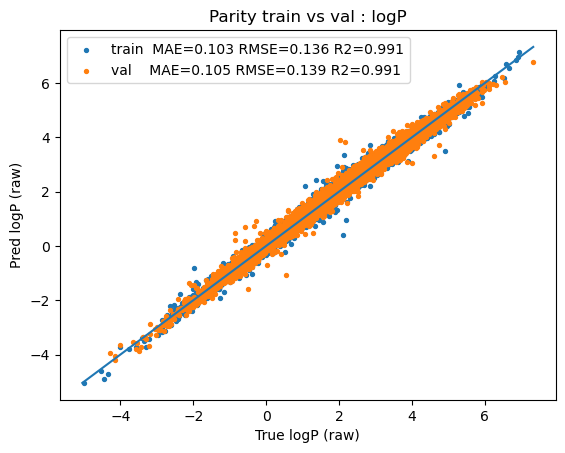

In [28]:
pred_tr, true_tr, smi_tr = predict_on_loader(model, train_loader, device, desc="predict(train)")
pred_va, true_va, smi_va = predict_on_loader(model, val_loader,   device, desc="predict(val)")
pred_te, true_te, smi_te = predict_on_loader(model, test_loader,  device, desc="predict(test)")

task_name = target_cols[0]           # 例: logP or qed, sas
task_idx = target_cols.index(task_name)

med, iqr = scalers[task_name]

plot_parity_train_val_1task(true_tr, pred_tr,
                            true_va, pred_va,
                            task_name,
                            task_idx,
                            title=f"Parity train vs val : {task_name}",
                            max_points=20000,
                            med=med, iqr=iqr)

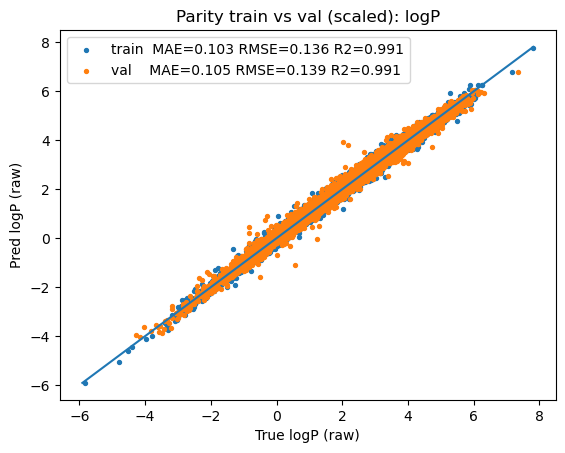

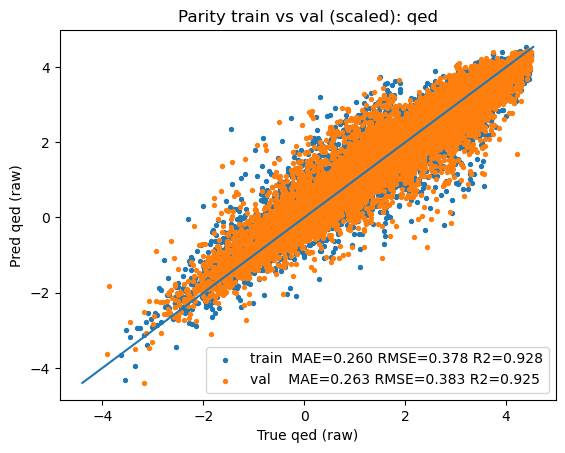

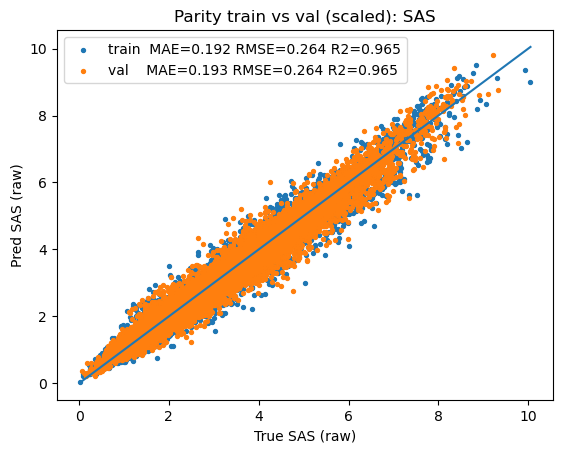

In [29]:
for task_name in target_cols:
    task_idx = target_cols.index(task_name)
    plot_parity_train_val_1task(true_tr, pred_tr, true_va, pred_va,
                                task_name, task_idx,
                                title=f"Parity train vs val (scaled): {task_name}",
                                max_points=20000,
                                med=med,
                                iqr=iqr)

## 保存

In [23]:
# ============================================================
# A) Utilities
# ============================================================

def ensure_dir(path: str):
    """
    保存先ディレクトリを作成
    すでに存在していてもエラーにならない
    """
    os.makedirs(path, exist_ok=True)

def build_versions() -> Dict[str, str]:
    """
    checkpointに環境情報を残すための辞書を作る関数
    """
    return {
        "python": f"{os.sys.version_info.major}.{os.sys.version_info.minor}.{os.sys.version_info.micro}",
        "torch": torch.__version__,
        "torch_geometric": torch_geometric.__version__,
        "rdkit": getattr(Chem, "__version__", "unknown"),
    }

def scalers_to_serializable(scalers: Dict[str, Tuple[float, float]]) -> Dict[str, Dict[str, float]]:
    """
    robust scalerの保存
    """
    return {k: {"median": float(v[0]), "iqr": float(v[1])} for k, v in scalers.items()}

def serializable_to_scalers(d: Dict[str, Dict[str, float]]) -> Dict[str, Tuple[float, float]]:
    """
    robust scalerの復元
    """
    return {k: (float(v["median"]), float(v["iqr"])) for k, v in d.items()}

def inverse_robust_scalar(x_scaled: float, med: float, iqr: float) -> float:
    """
    推論で得たscaledの出力を元のスケールに戻す
    """
    return float(x_scaled * iqr + med)

def canonicalize_smiles(smi: str) -> Optional[str]:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, canonical=True)

# ============================================================
# B) Preprocess registry (SMILES -> PyG Data)
#    Add new preprocessers here in the future.
# ============================================================

def smiles_to_pyg_discrete_v2(smiles: str):
    """
    smiles→RDKit Mol→PyG Data への変換関数（離散原子・結合特徴 v2）
    Your current preprocessing:
      - node features: atom_features() -> long[5]
      - edge features: bond_features() -> long[3] (0th is bond_type)
    Returns: torch_geometric.data.Data or None
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.stack([atom_features(a) for a in mol.GetAtoms()], dim=0)  # [N, 5]

    edge_index_list, edge_attr_list = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bf = bond_features(bond)
        edge_index_list += [[i, j], [j, i]]
        edge_attr_list  += [bf, bf]

    if len(edge_index_list) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr  = torch.empty((0, 3), dtype=torch.long)
    else:
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr  = torch.stack(edge_attr_list, dim=0)

    from torch_geometric.data import Data
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.smiles = smiles
    return data

# 文字列キー→関数の辞書
PREPROCESS_REGISTRY: Dict[str, Callable[[str], Any]] = {
    "discrete_atom_bond_v2": smiles_to_pyg_discrete_v2,
    # future:
    # "deep4chem_pair_concat": ...,
    # "3d_conformer": ...,
}

# ============================================================
# C) Model registry
#    Add new models here in the future.
# ============================================================

def build_mpnn_edgecond_gru(model_config: Dict[str, Any]):
    """
    checkpointで保存したmodel_configを使ってモデルを再構築
    Reconstruct your MPNNRegressor from config.
    """
    return MPNNRegressor(
        hidden_dim=int(model_config["hidden_dim"]),
        num_layers=int(model_config["num_layers"]),
        num_targets=int(model_config["num_targets"]),
        dropout=float(model_config.get("dropout", 0.0)),
    )

MODEL_REGISTRY: Dict[str, Callable[[Dict[str, Any]], torch.nn.Module]] = {
    "mpnn_edgecond_gru": build_mpnn_edgecond_gru,
    # future:
    # "gin": ...,
    # "gat": ...,
}

# ============================================================
# D) Generic save / load
# ============================================================

def save_checkpoint_generic(
    model: torch.nn.Module,                                 # 学習済みのPyTorchモデル
    dataset_name: str,                                      # 保存先のフォルダ名
    target_cols: List[str],                                 # 出力タスク名の順序
    scalers: Dict[str, Tuple[float, float]],                # robust scaler
    save_root: str = "models",                              # ルート
    ckpt_name: str = "checkpoint.pt",                       # チェックポイント名
    model_name: str = "mpnn_edgecond_gru",
    preprocess_name: str = "discrete_atom_bond_v2",
    model_config: Optional[Dict[str, Any]] = None,
    preprocess_config: Optional[Dict[str, Any]] = None,
):
    """
    Save a single checkpoint + optional json sidecars.

    Folder: {save_root}/{dataset_name}/
    """
    save_dir = os.path.join(save_root, dataset_name)
    ensure_dir(save_dir)

    ckpt_path = os.path.join(save_dir, ckpt_name)

    # Build minimal model_config if not provided
    if model_config is None:
        model_config = {
            "model_name": model_name,
            "hidden_dim": int(getattr(model, "layers", None)[0].hidden_dim) if hasattr(model, "layers") else 128,
            "num_layers": int(len(model.layers)) if hasattr(model, "layers") else 3,
            "dropout": float(getattr(model, "dropout", 0.0)),
            "fp_dim": int(getattr(model, "fp_dim", 1024)),
            "num_targets": int(len(target_cols)),
            "target_cols": list(target_cols),  # ORDER IS CRITICAL
        }
    else:
        # enforce critical fields
        model_config = dict(model_config)
        model_config["model_name"] = model_name
        model_config["num_targets"] = int(len(target_cols))
        model_config["target_cols"] = list(target_cols)

    if preprocess_config is None:
        preprocess_config = {
            "preprocess_name": preprocess_name,
            "smiles_canonicalize": True,
            "rdkit_sanitize": True,
        }
    else:
        preprocess_config = dict(preprocess_config)
        preprocess_config["preprocess_name"] = preprocess_name

    payload = {
        "state_dict": model.state_dict(),
        "dataset_name": dataset_name,
        "model_config": model_config,
        "preprocess_config": preprocess_config,
        "scalers": scalers_to_serializable(scalers),
        "versions": build_versions(),
    }

    torch.save(payload, ckpt_path)

    # sidecars (human-readable)
    with open(os.path.join(save_dir, "model_config.json"), "w", encoding="utf-8") as f:
        json.dump(model_config, f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "preprocess_config.json"), "w", encoding="utf-8") as f:
        json.dump(preprocess_config, f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "scalers.json"), "w", encoding="utf-8") as f:
        json.dump(payload["scalers"], f, indent=2, ensure_ascii=False)
    with open(os.path.join(save_dir, "versions.json"), "w", encoding="utf-8") as f:
        json.dump(payload["versions"], f, indent=2, ensure_ascii=False)

    print(f"Saved: {ckpt_path}")
    return ckpt_path


class GenericGNNPredictor:
    """
    一回ロードしたら、何度でもsmiles予測できるオブジェクト
    Load once, predict many.
    """
    def __init__(self, ckpt_path: str, device: Optional[torch.device] = None):
        self.ckpt_path = ckpt_path
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # payloadの読み込み
        payload = torch.load(ckpt_path, map_location="cpu")

        # model_config, preprocess_config, scalersの復元
        self.dataset_name = payload.get("dataset_name", "unknown")
        self.model_config = payload["model_config"]
        self.preprocess_config = payload["preprocess_config"]
        self.scalers = serializable_to_scalers(payload["scalers"])
        self.versions = payload.get("versions", {})
        self.target_cols = list(self.model_config["target_cols"])
        self.num_targets = int(self.model_config["num_targets"])

        # model_nameを見てMODEL_REGISTRYからモデルを構築
        model_name = self.model_config.get("model_name")
        if model_name not in MODEL_REGISTRY:
            raise ValueError(f"Unknown model_name='{model_name}'. Available: {list(MODEL_REGISTRY.keys())}")
        self.model = MODEL_REGISTRY[model_name](self.model_config).to(self.device)
        # state_dictをロードしてevalモードに
        self.model.load_state_dict(payload["state_dict"])
        self.model.eval()

        # preprocess_nameを見てPREPROCESS_REGISTRYから変換関数を取得
        preprocess_name = self.preprocess_config.get("preprocess_name")
        if preprocess_name not in PREPROCESS_REGISTRY:
            raise ValueError(f"Unknown preprocess_name='{preprocess_name}'. Available: {list(PREPROCESS_REGISTRY.keys())}")
        self.smiles_to_data = PREPROCESS_REGISTRY[preprocess_name]

        self.do_canonicalize = bool(self.preprocess_config.get("smiles_canonicalize", True))

    @torch.no_grad()
    def predict_smiles(self, smiles: str) -> Dict[str, Any]:
        smi_in = smiles
        smi = smiles

        if self.do_canonicalize:
            smi2 = canonicalize_smiles(smi)
            if smi2 is None:
                return {"ok": False, "smiles_in": smi_in, "error": "Invalid SMILES"}
            smi = smi2

        data = self.smiles_to_data(smi)
        if data is None:
            return {"ok": False, "smiles_in": smi_in, "smiles_used": smi, "error": "Failed to build graph"}

        # Batch of 1
        from torch_geometric.loader import DataLoader
        batch = next(iter(DataLoader([data], batch_size=1, shuffle=False))).to(self.device)

        pred_scaled = self.model(batch).detach().cpu().view(-1)  # [T]
        if pred_scaled.numel() != self.num_targets:
            return {
                "ok": False,
                "smiles_in": smi_in,
                "smiles_used": smi,
                "error": f"Pred dim mismatch: got {pred_scaled.numel()} expected {self.num_targets}"
            }

        pred_scaled_dict = {t: float(pred_scaled[i].item()) for i, t in enumerate(self.target_cols)}

        pred_raw_dict = {}
        for i, t in enumerate(self.target_cols):
            med, iqr = self.scalers[t]
            pred_raw_dict[t] = inverse_robust_scalar(float(pred_scaled[i].item()), med, iqr)

        return {
            "ok": True,
            "dataset": self.dataset_name,
            "smiles_in": smi_in,
            "smiles_used": smi,
            "pred_scaled": pred_scaled_dict,
            "pred_raw": pred_raw_dict,
        }

    @torch.no_grad()
    def predict_smiles_list(self, smiles_list: List[str]) -> pd.DataFrame:
        rows = []
        for smi in smiles_list:
            res = self.predict_smiles(smi)
            if not res["ok"]:
                rows.append({
                    "smiles_in": res.get("smiles_in", smi),
                    "smiles_used": res.get("smiles_used", ""),
                    "ok": False,
                    "error": res.get("error", "unknown"),
                })
                continue

            row = {
                "smiles_in": res["smiles_in"],
                "smiles_used": res["smiles_used"],
                "ok": True,
                "error": "",
            }
            for t in self.target_cols:
                row[t] = res["pred_raw"][t]
                row[f"{t}_scaled"] = res["pred_scaled"][t]
            rows.append(row)

        return pd.DataFrame(rows)


def load_predictor_generic(
    dataset_name: str,
    save_root: str = "models",
    ckpt_name: str = "checkpoint.pt",
    device: Optional[torch.device] = None,
) -> GenericGNNPredictor:
    ckpt_path = os.path.join(save_root, dataset_name, ckpt_name)
    return GenericGNNPredictor(ckpt_path=ckpt_path, device=device)

In [24]:
ckpt_path = save_checkpoint_generic(
    model=model,
    dataset_name="zinc",
    target_cols=target_cols,   # ["logP","qed","SAS"]
    scalers=scalers,           # {"logP":(med,iqr), "qed":(...), "SAS":(...)}
    save_root="models",
    ckpt_name="checkpoint.pt",
    model_name="mpnn_edgecond_gru",
    preprocess_name="discrete_atom_bond_v2",
)

Saved: models/zinc/checkpoint.pt


## 復元

In [25]:
predictor = load_predictor_generic(dataset_name="zinc", save_root="models", ckpt_name="checkpoint.pt")

res = predictor.predict_smiles("CCO")
print(res["pred_raw"])    # {"logP":..., "qed":..., "SAS":...}

df = predictor.predict_smiles_list(["CCO", "c1ccccc1", "invalid"])
display(df)

{'logP': 0.25158007044553754, 'qed': 0.35975909160570496, 'SAS': 2.5251342090132924}


[21:51:21] SMILES Parse Error: syntax error while parsing: invalid
[21:51:21] SMILES Parse Error: check for mistakes around position 1:
[21:51:21] invalid
[21:51:21] ^
[21:51:21] SMILES Parse Error: Failed parsing SMILES 'invalid' for input: 'invalid'


,smiles_in,smiles_used,ok,error,logP,logP_scaled,qed,qed_scaled,SAS,SAS_scaled
0,CCO,CCO,True,,0.251580,-1.231428,0.359759,-2.106985,2.525134,-0.325682
1,c1ccccc1,c1ccccc1,True,,1.719683,-0.463504,0.424181,-1.767564,1.559915,-1.180598
2,invalid,,False,Invalid SMILES,NaN,NaN,NaN,NaN,NaN,NaN
